<h1 align="center">ENGC63 - 3º Projeto</h1>

**Universidade Federal da Bahia - UFBA**

**Disciplina :** Processamento Digital de Sinais

**Discentes :** Miguel Feliciano Mota Alves e Rodrigo Freitas Sá Barretto

## Introdução

A janela de kaiser é definida por:

$$
w[n] = 
\begin{cases}
\displaystyle
\frac{I_0[\beta(1-[\frac{(n-\alpha)}{\alpha}]^2)^{1/2}]}{I_0(\beta)}\\
0, & \text{caso contrário}
\end{cases}
$$

onde $\alpha = M/2$ e $I_0(\cdot)$ é a função de Besel modificada.

Para implementar o filtro FIR utilizando a **janela de Kaiser**, diferentemente dos outros tipos de janela, primeiro define-se as especificações do filtro desejado e, com as especificações definidas, calcula-se os parâmetros da janela $\beta$ e $M$ da janela.

## Dados do Projeto

A seguir estão as especificações definidas para o projeto do filtro.

### 1. Especificações de Frequência

Com uma frequência de corte central ($\omega_c$) e uma largura de banda de transição ($\Delta\omega$) definidas, as frequências da banda de passagem ($\omega_p$) e da banda de rejeição ($\omega_s$) podem ser encontradas a partir delas.

* **Frequência de Corte Central ($\omega_c$):**
    $$\omega_c = \frac{\pi}{2} \text{ rad/amostra}$$

* **Largura da Banda de Transição ($\Delta\omega$):**
    $$\Delta\omega = 0.1\pi \text{ rad/amostra}$$

* **Banda de Passagem:** O filtro deve passar frequências no intervalo $[0, \omega_p]$, $\omega_p = \omega_c - (\Delta\omega/2)$.
    $$0 \le \omega \le 0.45\pi \text{ rad/amostra}$$

* **Banda de Rejeição:** O filtro deve rejeitar frequências no intervalo $[\omega_s, \pi]$, $\omega_s = \omega_c + (\Delta\omega/2)$, até $\pi$.
    $$0.55\pi \le \omega \le \pi \text{ rad/amostra}$$

### 2. Ripple e Atenuação

Como, para o projeto por janela, o filtro resultante terá o mesmo erro de pico na banda de passagem e na banda de rejeição, isto é, $\delta_p = \delta_s$ e a atenuação na banda de rejeição pode ser definida por:

$$A_s = -20 \log_{10}(|H(e^{j\omega})|) \ge 50 \text{ dB}$$

portanto:

$$\delta_p = \delta_s \approx 0.00316$$

### 3. Intervalos de Tolerância

Com base nas especificações de frequência e nos valores de *ripple* definidos, os intervalos de tolerância para a magnitude da resposta em frequência, $|H(e^{j\omega})|$, são os seguintes:

* **Na Banda de Passagem ($0 \le \omega \le 0.45\pi$):** O ganho deve estar dentro do seguinte intervalo: 
    $$0.99684 \le |H(e^{j\omega})| \le 1.00316$$

* **Na Banda de Rejeição ($0.55\pi \le \omega \le \pi$):** O ganho deve ser suprimido para o seguinte intervalo:
    $$ 0 \le |H(e^{j\omega})| \le 0.00316$$

In [1]:
from scipy.signal import kaiserord, firwin, freqz, tf2sos, sosfreqz
import numpy as np  #np.np.pi, log10, abs, arange, where, angle, unwrap, gradient
import matplotlib.pyplot as plt

In [2]:
w_cutoff = np.pi / 2                  # Frequência de corte [rad/amostra]
w_transition = 0.1 * np.pi            # Região de transição [rad/amostra]
A = 50                                # Atenuação [dB]
w_pass = w_cutoff - w_transition/2    # Banda de passagem [rad/amostra]
w_stop = w_cutoff + w_transition/2    # Banda de rejeição [rad/amostra]
erro = 0.00316                        # Erro máximo

print(f"Frequência de corte: {w_cutoff/np.pi}π")
print(f"Região de transição: {w_transition/np.pi}π")
print(f"Banda de passagem: {w_pass/np.pi}π")
print(f"Banda de rejeição: {w_stop/np.pi}π")
print(f"Atenuação: {A} dB")
print(f"Erro máximo: {erro}")

Frequência de corte: 0.5π
Região de transição: 0.1π
Banda de passagem: 0.45π
Banda de rejeição: 0.55π
Atenuação: 50 dB
Erro máximo: 0.00316


In [3]:
M, beta = kaiserord(A, w_transition / np.pi) # Calcula a ordem e o beta da janela kaiser
print(f"Ordem do filtro: {M}")
print(f"β = {beta}")

Ordem do filtro: 60
β = 4.533514120981248


Para este projeto, a ordem escolhida do filtro será PAR, para que o filtro projetado seja de tipo 1 e não imponha restrições. Isso é essencial para uma etapa futura do trabalho, onde serão feitas transformações do filtro passa-baixas para outros tipos de filtro (e.g. passa-altas). Se outros tipos de filtro fossem utilizados, as restrições existentes para esses tipos poderiam levar a resultados indesejados.

In [4]:
'''
1 - numtaps = Ordem(FIR) + 1, se M é par, numtaps é impar
2 - Cria o filtro usando a janela Kaiser
3 - Cutoff precisa ser normalizado
4 - Por padrão a biblioteca scipy implementa o filtro na forma direta
''' 
fir_direct = firwin(numtaps=M+1, cutoff=w_cutoff / np.pi, window=("kaiser", beta), pass_zero="lowpass")

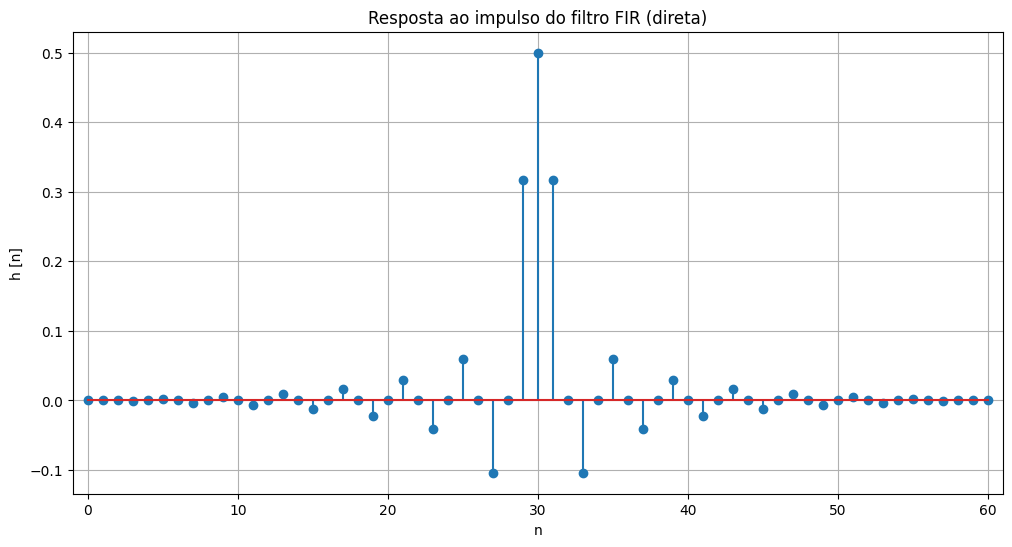

In [5]:
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(fir_direct)), fir_direct)
plt.title('Resposta ao impulso do filtro FIR (direta)')
plt.xlabel('n')
plt.ylabel('h [n]')
xlim = [-1, 61]
plt.xlim(xlim)
plt.grid(True)
plt.show()

Como esperado do filtro passa-baixas (tipo I) projetado, a resposta ao impulso do filtro projetado se aproxima de uma função sinc, com comprimento $M + 1$, com simetria par e centrada em $M/2$

In [6]:
omega_direct, response_direct = freqz(fir_direct, worN=10192)       # Calcula resposta do filtro na forma direta
omega_direct_norm = omega_direct / np.pi                            # Normaliza a frequência para o intervalo [0, 1]

In [7]:
# Cria um filtro passa-baixas ideal para comparação e cálculo de erro
lpf_ideal = np.where(omega_direct_norm <= w_cutoff / np.pi, 1.0, 0.0) 

In [10]:
def plot_response_direct(omega_direct_norm_X, response_direct_X, form:str, gd_flag:bool=False):
    fir_direct_mag = abs(response_direct_X)                               # |H(e^jw)|
    response_direct_dB = 20 * np.log10(abs(response_direct_X))            # Resposta em dB
    phase_direct = np.unwrap(np.angle(response_direct_X))                 # Fase unwraped
    group_delay_direct = -np.gradient(phase_direct, omega_direct)         # Atraso de grupo
    
    linhas = 4 if gd_flag else 3
    
    fig, axes = plt.subplots(linhas, 1, figsize=(14, 14))

    # Gráfico 1: |H(e^jw)|
    axes[0].plot(omega_direct_norm_X, fir_direct_mag, label="Resposta Passa-Baixas Kaiser", color='blue', linewidth=2)
    axes[0].plot(omega_direct_norm_X, lpf_ideal, color="orange", linestyle="--", linewidth=1.3, label="LPF Ideal")
    axes[0].set_title('Magnitude X Resposta Ideal')
    axes[0].set_xlabel('Frequência Normalizada (ω / π)')
    axes[0].set_ylabel('|H(e^jw)|')
    axes[0].set_xticks(np.arange(0, 1.05, 0.05))
    axes[0].set_xlim(0, 1.0)
    axes[0].set_ylim(-0.05, 1.1)
    axes[0].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
    axes[0].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
    axes[0].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
    axes[0].legend()

    # Gráfico 2: Ganho em dB
    axes[1].plot(omega_direct_norm_X, response_direct_dB, color='blue', linewidth=2, label='Magnitude [dB]')
    axes[1].set_title('Magnitude Logarítimica')
    axes[1].set_xlabel('Frequência Normalizada (ω / π)')
    axes[1].set_ylabel('dB')
    axes[1].set_xticks(np.arange(0, 1.05, 0.05))
    axes[1].set_yticks(np.arange(-100, 10, 10))
    axes[1].set_ylim(-100, 5)
    axes[1].set_xlim(0, 1.0)
    axes[1].axhline(-50, color='orange', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
    axes[1].axvline(0.50, color='purple', linestyle='--', linewidth=1.5, label='ω cutoff')
    axes[1].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
    axes[1].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
    axes[1].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
    axes[1].grid(True, which='both', linestyle=':', linewidth=0.8)
    axes[1].legend()


    # Gráfico 2: Fase
    axes[2].plot(omega_direct_norm_X, phase_direct, color='purple')
    axes[2].set_title('Fase (Unwraped)')
    axes[2].set_xlabel('Frequência Normalizada (ω / π)')
    axes[2].set_ylabel('Fase')
    axes[2].set_xticks(np.arange(0, 1.05, 0.05))
    axes[2].grid(True)

    # Gráfico 3: Atraso de Grupo
    if gd_flag:
        axes[3].plot(omega_direct_norm_X, group_delay_direct, color='darkgreen')
        axes[3].set_title('Atraso de Grupo')
        axes[3].set_xlabel('Frequência Normalizada (ω / π)')
        axes[3].set_ylabel('Atraso de Grupo')
        axes[3].set_xticks(np.arange(0, 1.05, 0.05))
        axes[3].grid(True)

    plt.suptitle(f'Filtro Passa-Baixas Kaiser Precisão Infinita ({form})', fontsize=14, y=1.0001)
    plt.tight_layout() 
    plt.show()

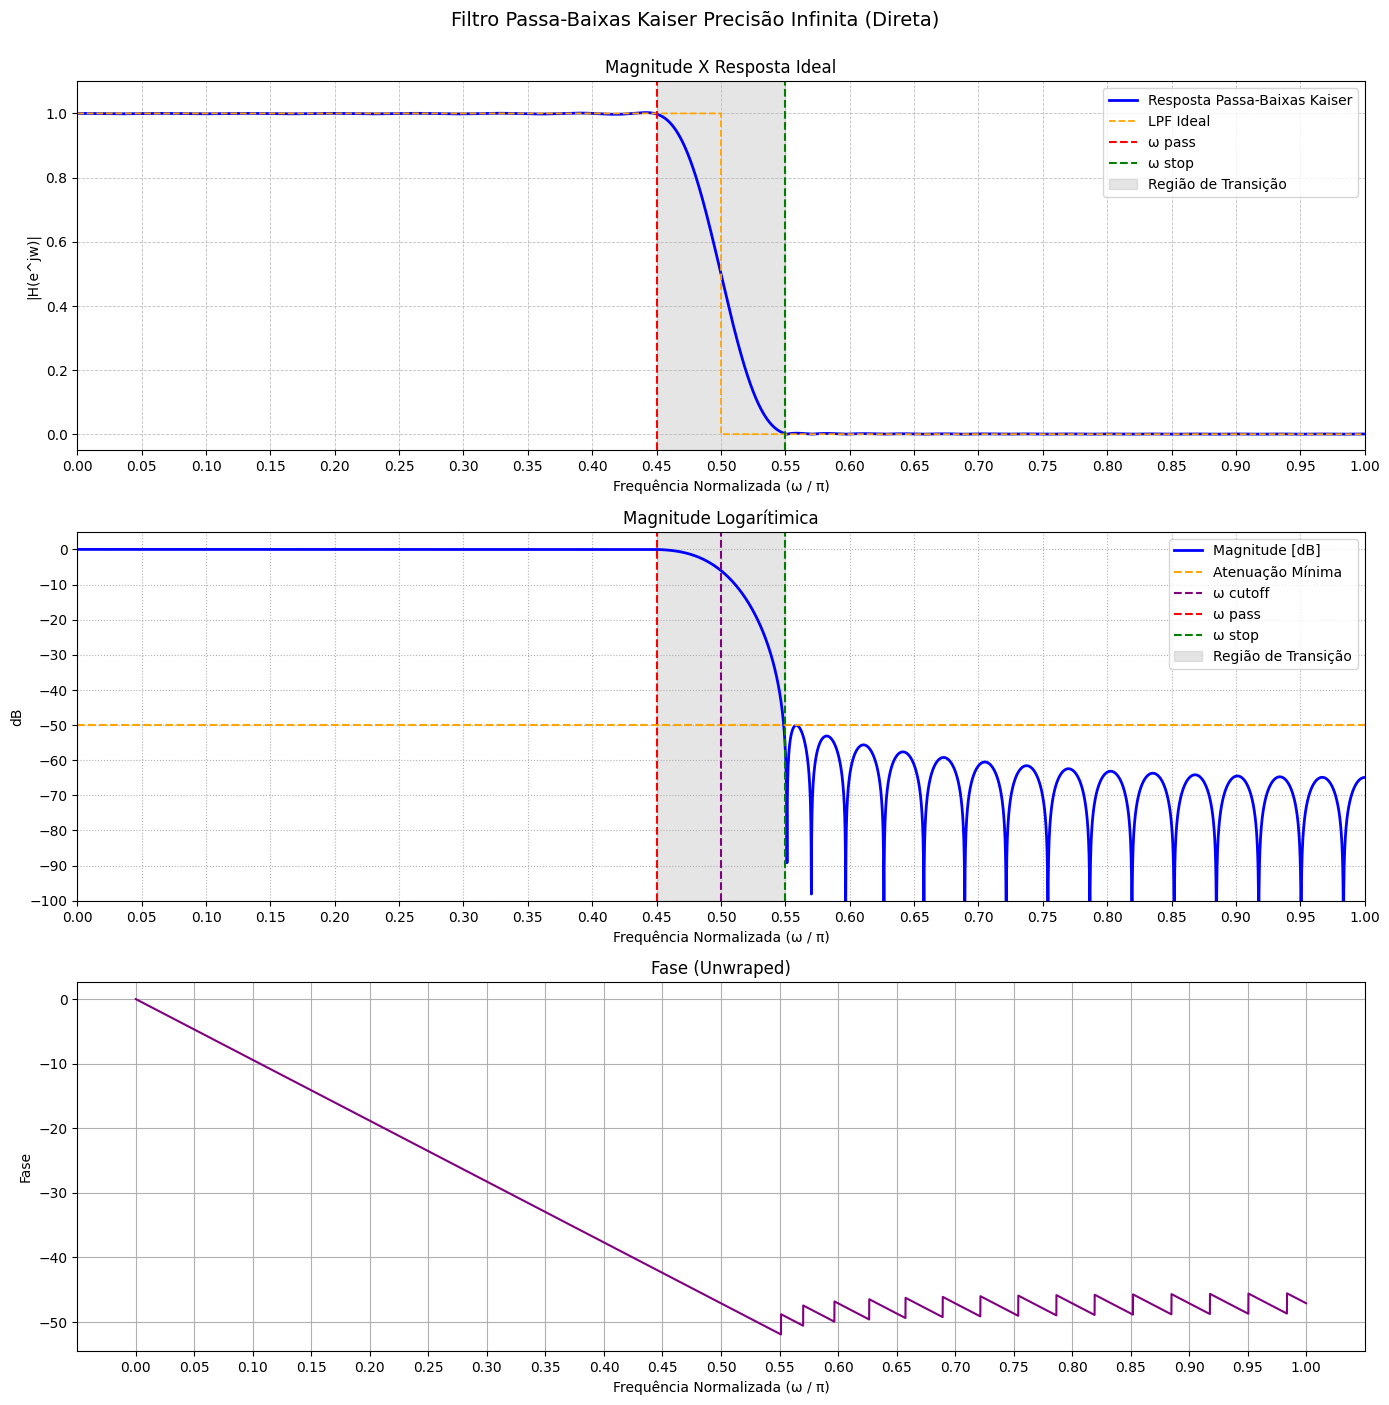

In [11]:
plot_response_direct(omega_direct_norm, response_direct, "Direta", False)

É possível observar que, ao utilizar o projeto por janela de Kaiser, tanto a banda passante quanto a banda de rejeição apresentam oscilações características. Esse comportamento está relacionado à limitação prática de não ser possível somar uma quantidade infinita de senoides na representação por séries de Fourier. Esse efeito é conhecido como fenômeno de Gibbs e é esperado para projetos de filtros que utilizando o janelamento.

Além disso, os gráficos da fase e do atraso de grupo apresentam o formato esperado para um filtro do tipo 1, onde na banda passante e na região de transição o atraso de grupo é constante, isto é, a fase é linear. Os impulsos na banda de rejeição ocorrem pois, nessa faixa, a magnitude assume valores muito baixos, o que leva problemas numéricos no cálculo da fase e, consequentemente, a variação rápida na fase, causa os impulsos no atraso de grupo.

Para a resposta em frequência (dB), fica evidente que, ao atingir a frequência de corte, o filtro está com uma atenuação de 50 dB. Além disso, também é possível perceber que os outros requisitos como largura da banda passante, da região de transição e outros também está sendo cumprida.

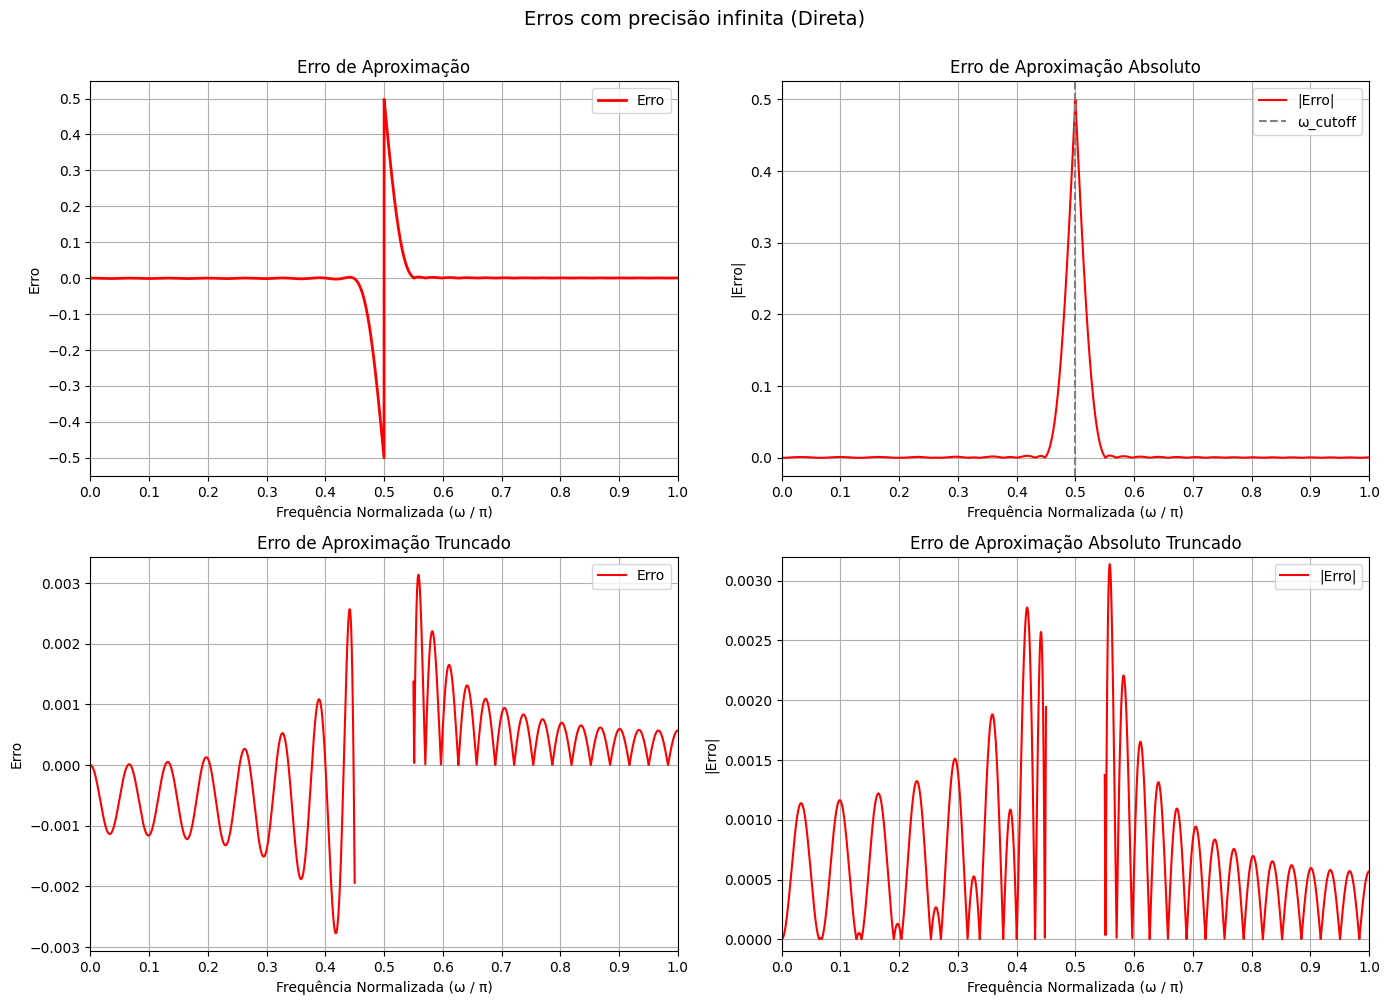

In [ ]:
# Erro de aproximação = H(ω) - LPF(ω)
erro = fir_direct_mag - lpf_ideal

# Erro de aproximação absoluto = |H(ω) - LPF(ω)|
erro_abs = abs(fir_direct_mag - lpf_ideal)

# Arrays de bools para truncar a resposta na faixa de transição
truncate_pass = omega_direct_norm <= w_pass / np.pi
truncate_stop = omega_direct_norm >= w_stop / np.pi

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Gráfico 1: Erro de aproximação
axes[0].plot(omega_direct_norm, erro, color='red', linewidth=2, label='Erro')
axes[0].set_title('Erro de Aproximação')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('Erro')
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0].set_yticks(np.arange(-0.5, 0.6, 0.1))
axes[0].set_xlim(0, 1.0)
axes[0].grid(True)
axes[0].legend()

# Gráfico 2: Erro absoluto de aproximação
axes[1].plot(omega_direct_norm, erro_abs, color='red', linewidth=1.5, label='|Erro|')
axes[1].axvline(w_cutoff / np.pi, color='grey', linestyle='--', label='ω_cutoff')
axes[1].set_title('Erro de Aproximação Absoluto')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('|Erro|')
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_xlim(0, 1.0)
axes[1].grid(True)
axes[1].legend()

# Gráfico 3: Erro de aproximação sem o np.pico para melhor visualização
axes[2].plot(omega_direct_norm[truncate_pass], erro[truncate_pass], color='red', linewidth=1.5, label='Erro')
axes[2].plot(omega_direct_norm[truncate_stop], erro[truncate_stop], color='red', linewidth=1.5)
axes[2].set_title('Erro de Aproximação Truncado')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Erro')
axes[2].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0032, 0.0032)
axes[2].set_xticks(np.arange(0, 1.1, 0.1))
axes[2].grid(True)
axes[2].legend()

# Gráfico 4:  Erro de aproximação absoluto sem o np.pico para melhor visualização
axes[3].plot(omega_direct_norm[truncate_pass], erro_abs[truncate_pass], color='red', linewidth=1.5, label='|Erro|')
axes[3].plot(omega_direct_norm[truncate_stop], erro_abs[truncate_stop], color='red', linewidth=1.5)
axes[3].set_title('Erro de Aproximação Absoluto Truncado')
axes[3].set_xlabel('Frequência Normalizada (ω / π)')
axes[3].set_ylabel('|Erro|')
axes[3].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0001, 0.0032)
axes[3].set_xticks(np.arange(0, 1.1, 0.1))
axes[3].grid(True)
axes[3].legend()

plt.suptitle('Erros com precisão infinita (Direta)', fontsize=14, y=1.0001)
plt.tight_layout()
plt.show()

Como esperado, o erro máximo de aproximação não excede o valor de $\delta_s$ previamente especificado, nem para a banda de passagem nem para a banda de rejeição. Observa-se também que o pico do erro ocorre em $\omega_c$, o que era previsto, dado que nesse ponto o filtro ideal do tipo passa-baixas apresenta uma descontinuidade (i.e. ele muda abruptamente de 1 para 0). Já o filtro projetado com a janela de Kaiser gera uma transição contínua, resultando em um desvio mais pronunciado exatamente nessa frequência.


In [ ]:
# Constrói o filtro usando a forma em cascata
fir_cascade = tf2sos(fir_direct, [1.0])

omega_cascade, response_cascade = sosfreqz(fir_cascade, worN=10192)   # Calcula resposta do filtro em cascata
omega_cascade_norm = omega_cascade / np.pi                            # Normaliza a frequência para o intervalo [0, 1]
fir_cascade_mag = abs(response_cascade)                               # |H(e^jw)|
response_cascade_dB = 20 * np.log10(abs(response_cascade))            # Resposta em dB
phase_cascade = np.unwrap(np.angle(response_cascade))                 # Fase desembrulhada
group_delay_cascade = -np.gradient(phase_cascade, omega_cascade)      # Atraso de grupo

/home/rodrigo/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


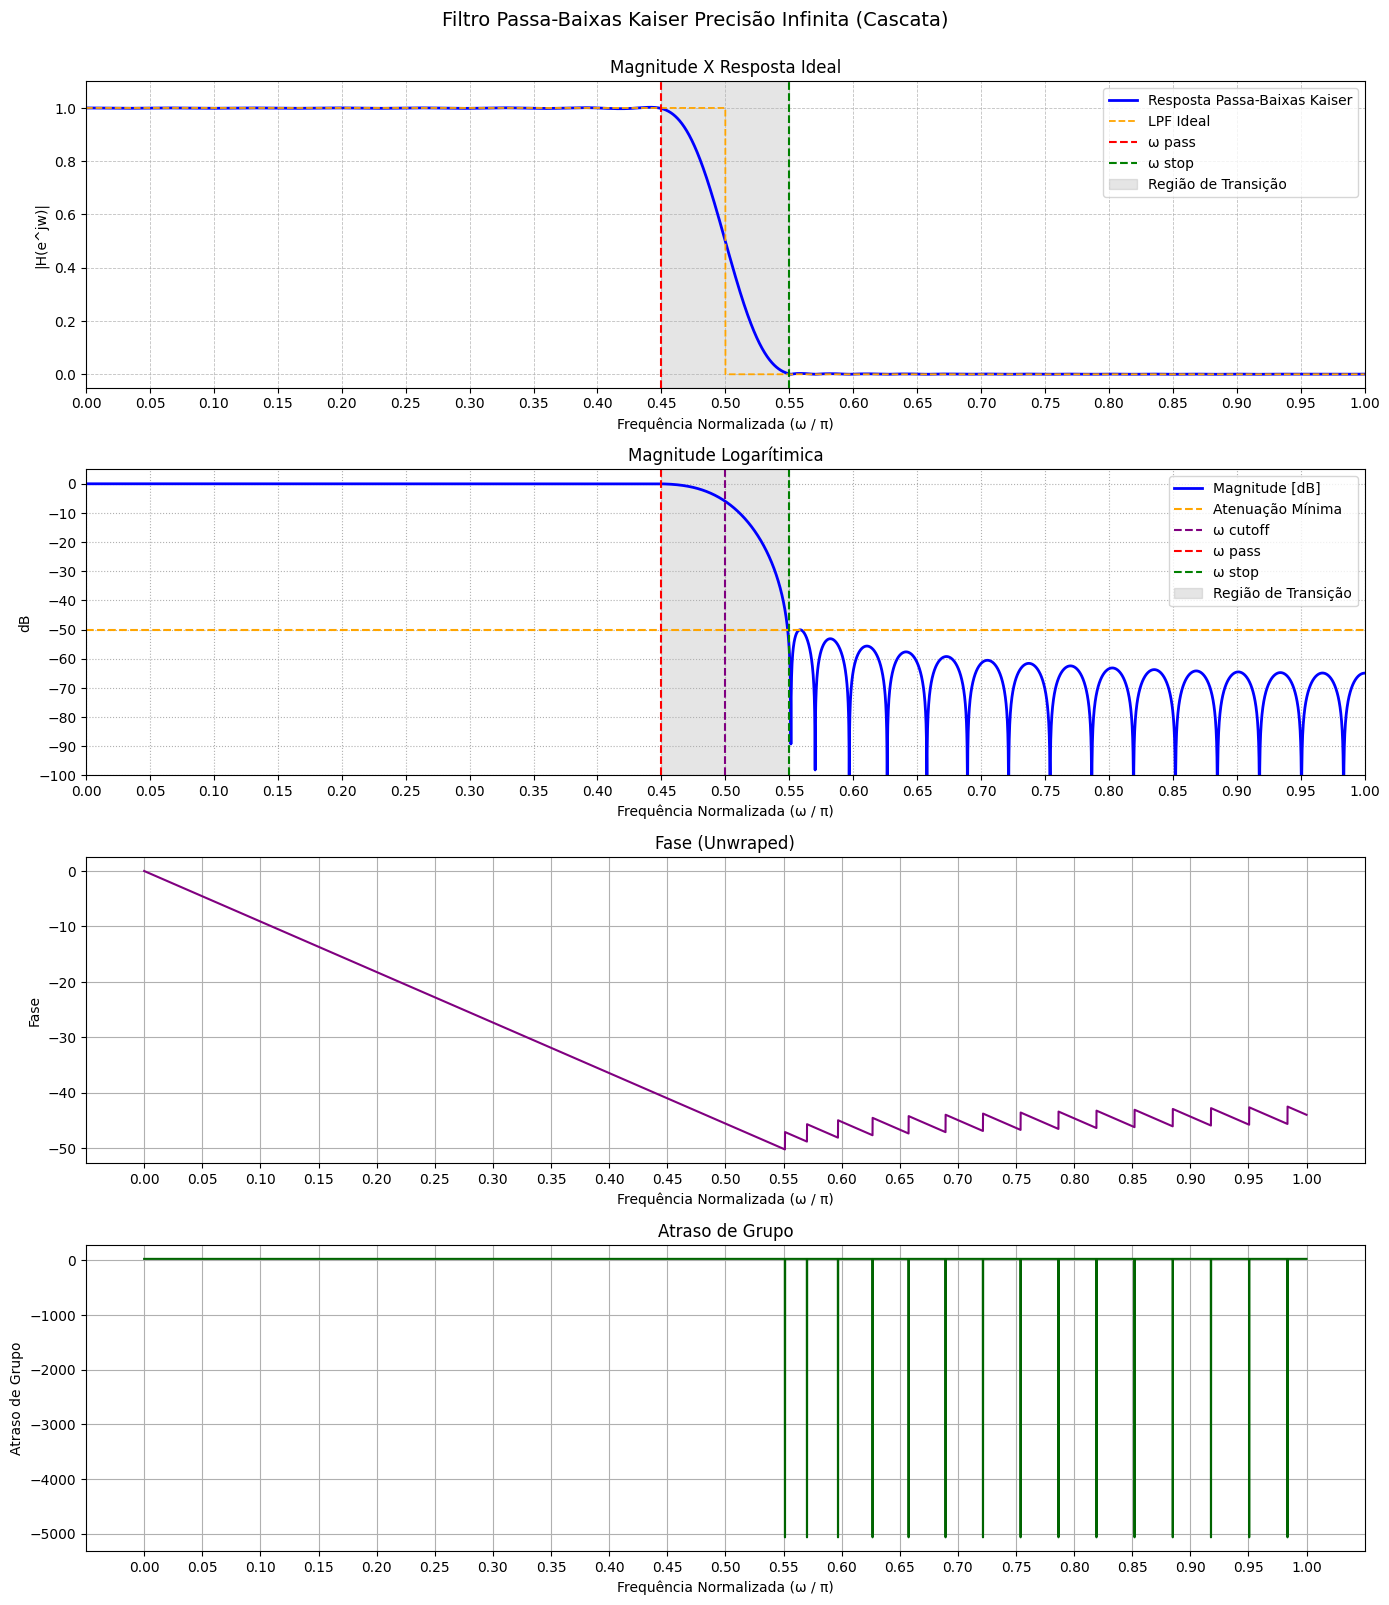

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(14, 14))

# Gráfico 1: |H(e^jw)|
axes[0].plot(omega_cascade_norm, fir_cascade_mag, label="Resposta Passa-Baixas Kaiser", color='blue', linewidth=2)
axes[0].plot(omega_cascade_norm, lpf_ideal, color="orange", linestyle="--", linewidth=1.3, label="LPF Ideal")
axes[0].set_title('Magnitude X Resposta Ideal')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('|H(e^jw)|')
axes[0].set_xticks(np.arange(0, 1.05, 0.05))
axes[0].set_xlim(0, 1.0)
axes[0].set_ylim(-0.05, 1.1)
axes[0].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
axes[0].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
axes[0].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
axes[0].grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
axes[0].legend()

# Gráfico 2: Ganho em dB
axes[1].plot(omega_cascade_norm, response_cascade_dB, color='blue', linewidth=2, label='Magnitude [dB]')
axes[1].set_title('Magnitude Logarítimica')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('dB')
axes[1].set_xticks(np.arange(0, 1.05, 0.05))
axes[1].set_yticks(np.arange(-100, 10, 10))
axes[1].set_ylim(-100, 5)
axes[1].set_xlim(0, 1.0)
axes[1].axhline(-50, color='orange', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
axes[1].axvline(0.50, color='purple', linestyle='--', linewidth=1.5, label='ω cutoff')
axes[1].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
axes[1].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
axes[1].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
axes[1].grid(True, which='both', linestyle=':', linewidth=0.8)
axes[1].legend()


# Gráfico 2: Fase
axes[2].plot(omega_cascade_norm, phase_cascade, color='purple')
axes[2].set_title('Fase (Unwraped)')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Fase')
axes[2].set_xticks(np.arange(0, 1.05, 0.05))
axes[2].grid(True)

# Gráfico 3: Atraso de Grupo
axes[3].plot(omega_cascade_norm, group_delay_cascade, color='darkgreen')
axes[3].set_title('Atraso de Grupo')
axes[3].set_xlabel('Frequência Normalizada (ω / π)')
axes[3].set_ylabel('Atraso de Grupo')
axes[3].set_xticks(np.arange(0, 1.05, 0.05))
axes[3].grid(True)

plt.suptitle('Filtro Passa-Baixas Kaiser Precisão Infinita (Cascata)', fontsize=14, y=1.0001)
plt.tight_layout()
plt.show()

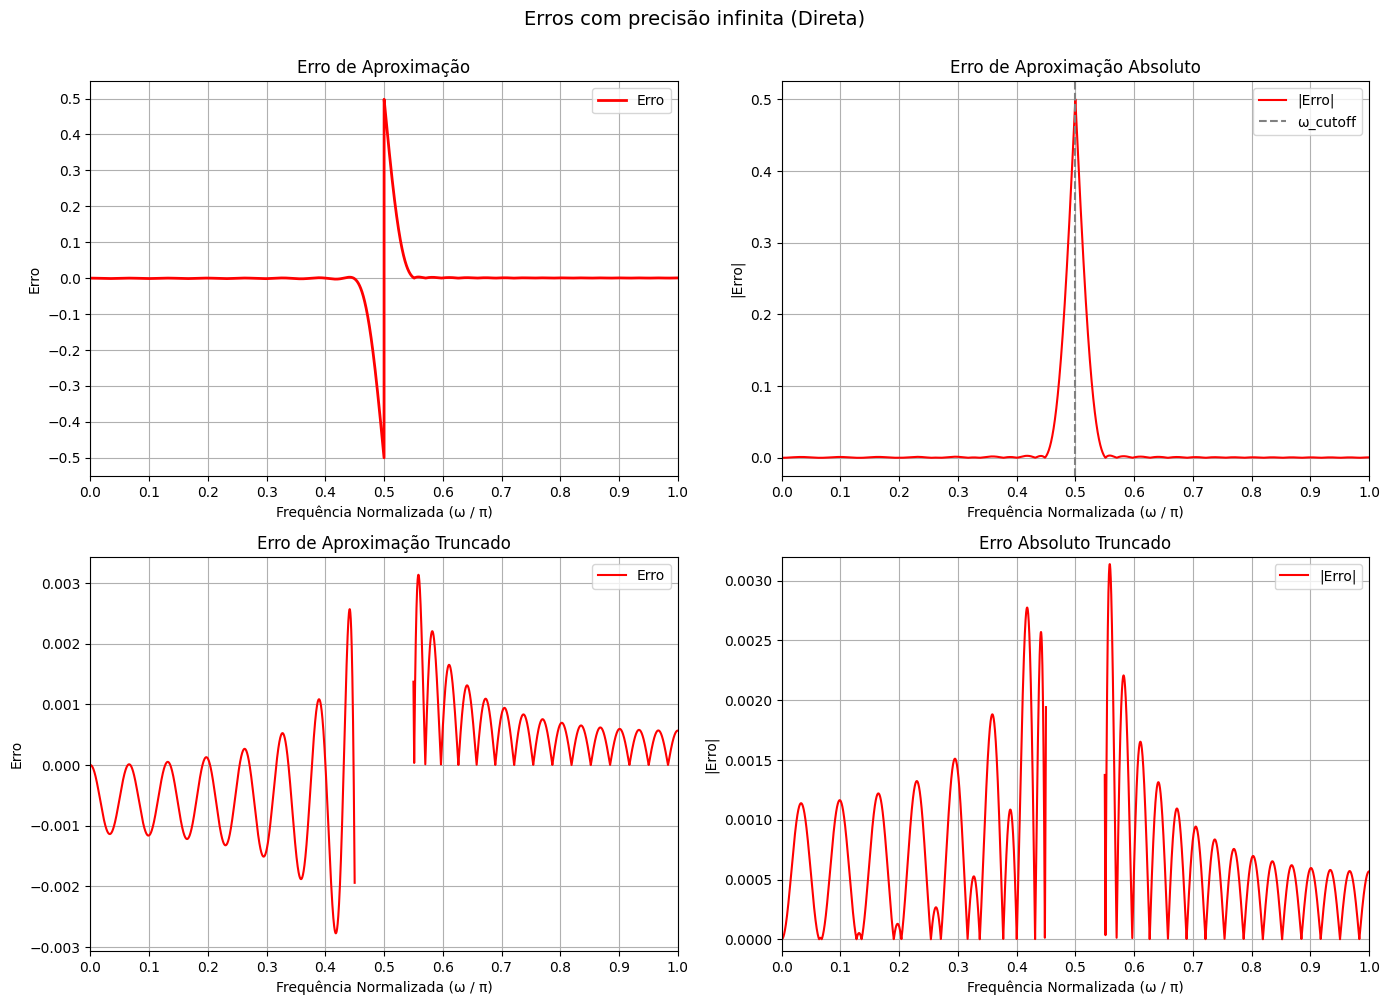

In [ ]:
# Erro de aproximação = H(ω) - LPF(ω)
erro = fir_cascade_mag - lpf_ideal

# Erro de aproximação absoluto = |H(ω) - LPF(ω)|
erro_abs = abs(fir_cascade_mag - lpf_ideal)

# Arrays de bools para truncar a resposta na faixa de transição
truncate_pass = omega_cascade_norm <= w_pass / np.pi
truncate_stop = omega_cascade_norm >= w_stop / np.pi

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Gráfico 1: Erro de aproximação
axes[0].plot(omega_cascade_norm, erro, color='red', linewidth=2, label='Erro')
axes[0].set_title('Erro de Aproximação')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('Erro')
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0].set_yticks(np.arange(-0.5, 0.6, 0.1))
axes[0].set_xlim(0, 1.0)
axes[0].grid(True)
axes[0].legend()

# Gráfico 2: Erro absoluto de aproximação
axes[1].plot(omega_cascade_norm, erro_abs, color='red', linewidth=1.5, label='|Erro|')
axes[1].axvline(w_cutoff / np.pi, color='grey', linestyle='--', label='ω_cutoff')
axes[1].set_title('Erro de Aproximação Absoluto')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('|Erro|')
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_xlim(0, 1.0)
axes[1].grid(True)
axes[1].legend()

# Gráfico 3: Erro de aproximação sem o pico para melhor visualização
axes[2].plot(omega_cascade_norm[truncate_pass], erro[truncate_pass], color='red', linewidth=1.5, label='Erro')
axes[2].plot(omega_cascade_norm[truncate_stop], erro[truncate_stop], color='red', linewidth=1.5)
axes[2].set_title('Erro de Aproximação Truncado')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Erro')
axes[2].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0032, 0.0032)
axes[2].set_xticks(np.arange(0, 1.1, 0.1))
axes[2].grid(True)
axes[2].legend()

# Gráfico 4:  Erro de aproximação absoluto sem o pico para melhor visualização
axes[3].plot(omega_cascade_norm[truncate_pass], erro_abs[truncate_pass], color='red', linewidth=1.5, label='|Erro|')
axes[3].plot(omega_cascade_norm[truncate_stop], erro_abs[truncate_stop], color='red', linewidth=1.5)
axes[3].set_title('Erro Absoluto Truncado')
axes[3].set_xlabel('Frequência Normalizada (ω / π)')
axes[3].set_ylabel('|Erro|')
axes[3].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0001, 0.0032)
axes[3].set_xticks(np.arange(0, 1.1, 0.1))
axes[3].grid(True)
axes[3].legend()

plt.suptitle('Erros com precisão infinita (Direta)', fontsize=14, y=1.0001)
plt.tight_layout()
plt.show()




Pela análise realizada, observa-se que, sob precisão infinita, a resposta em frequência dos filtros projetados nas formas direta e em cascata apresenta variações insignificantes. Conforme descrito por Oppenheim, Schafer e Buck (2010):

> OPPENHEIM, Alan V.; SCHAFER, Ronald W.; BUCK, John R. *Processamento de sinais em tempo discreto*. 3. ed. São Paulo: Pearson Prentice Hall, 2010.

Esse comportamento é esperado, uma vez que ambas as implementações são teoricamente equivalentes na ausência de limitações numéricas. Neste caso, a precisão de 64 bits em ponto flutuante utilizada pela linguagem de programação é suficiente para que os efeitos da quantização sejam desprezíveis.

Para avaliar os impactos da precisão numérica, os mesmos filtros serão projetados a seguir com restrições na representação dos coeficientes.


In [ ]:
fir_direct_8dec = np.round(fir_direct, 8)

omega_direct_8dec, response_direct_8dec = freqz(fir_direct_8dec, worN=10192) # Calcula resposta do filtro na forma direta
omega_direct_norm_8dec = omega_direct_8dec / np.pi                           # Normaliza a frequência para o intervalo [0, 1]
fir_direct_mag_8dec = abs(response_direct_8dec)                              # |H(e^jw)|
response_direct_dB_8dec = 20 * np.log10(abs(response_direct_8dec))           # Resposta em dB
phase_direct_8dec = np.unwrap(np.angle(response_direct_8dec))                # Fase desembrulhada

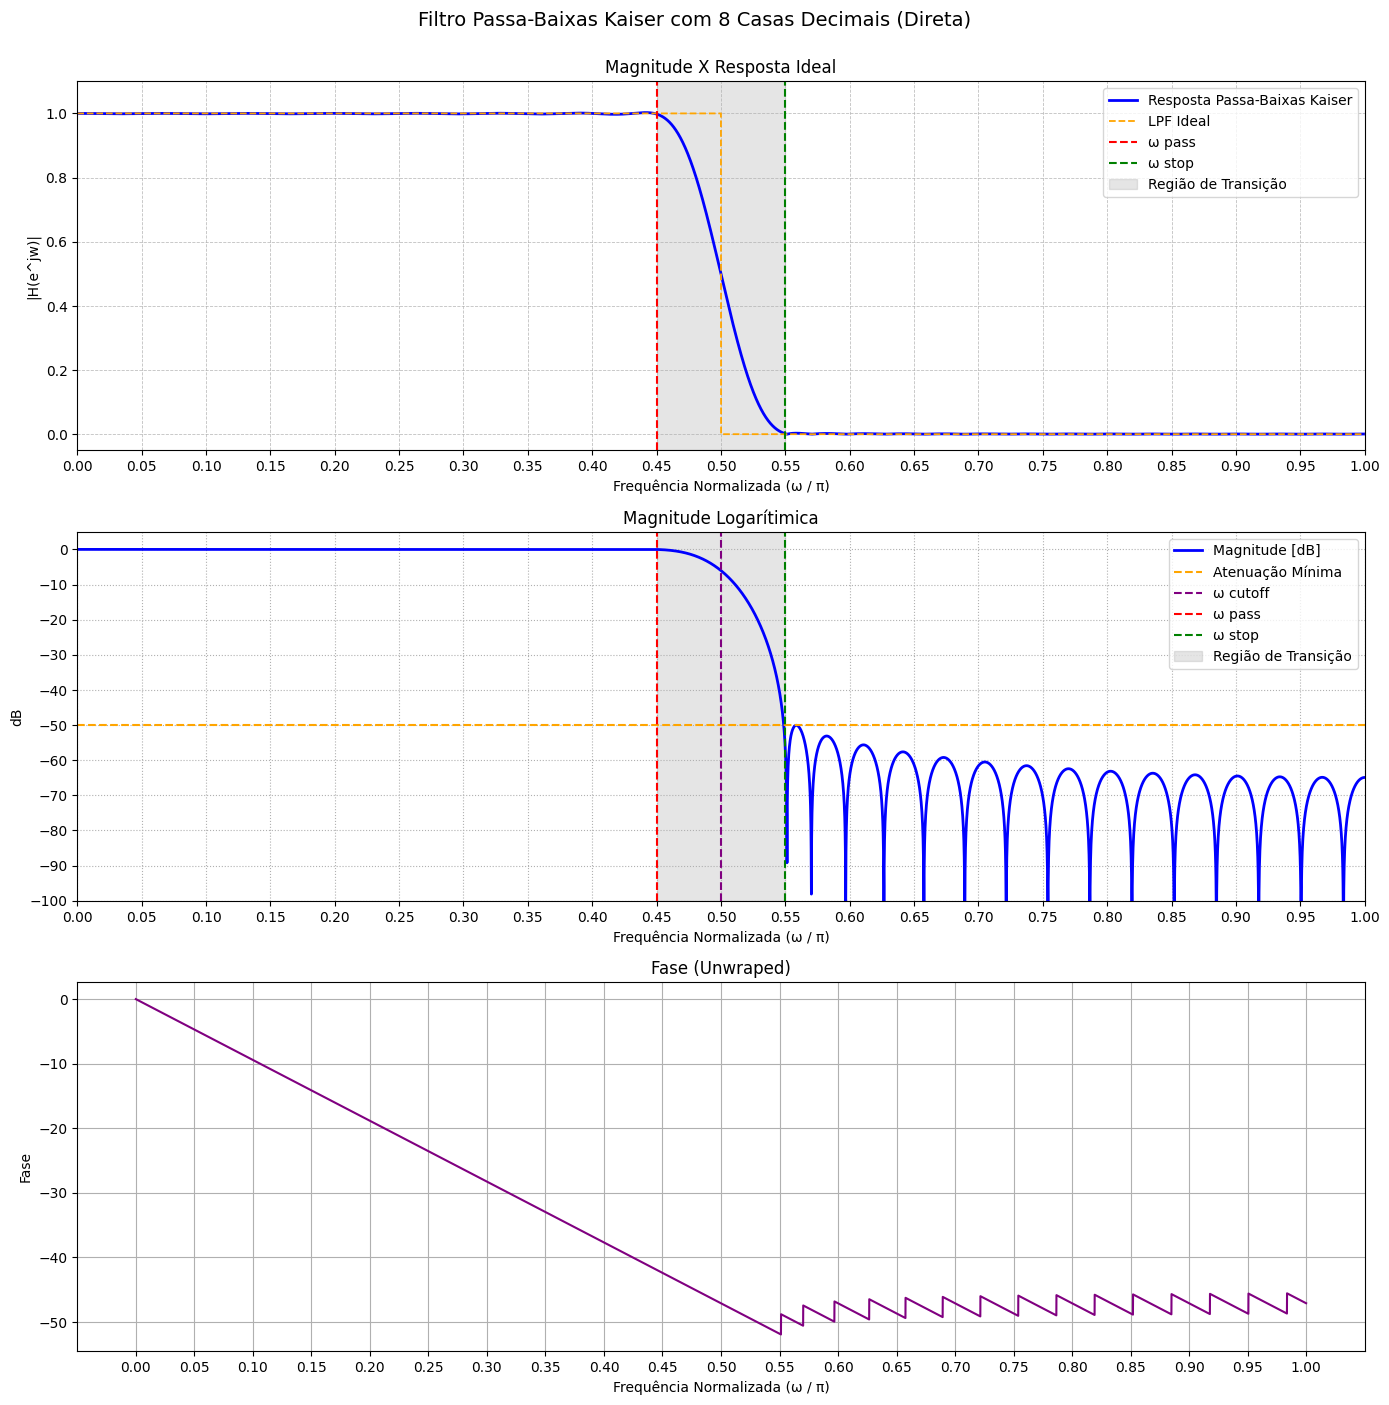

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Gráfico 1: |H(e^jw)|
axes[0].plot(omega_direct_norm_8dec, fir_direct_mag_8dec, label="Resposta Passa-Baixas Kaiser", color='blue', linewidth=2)
axes[0].plot(omega_direct_norm_8dec, lpf_ideal, color="orange", linestyle="--", linewidth=1.3, label="LPF Ideal")
axes[0].set_title('Magnitude X Resposta Ideal')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('|H(e^jw)|')
axes[0].set_xticks(np.arange(0, 1.05, 0.05))
axes[0].set_xlim(0, 1.0)
axes[0].set_ylim(-0.05, 1.1)
axes[0].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
axes[0].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
axes[0].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
axes[0].grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
axes[0].legend()

# Gráfico 2: Ganho em dB
axes[1].plot(omega_direct_norm_8dec, response_direct_dB_8dec, color='blue', linewidth=2, label='Magnitude [dB]')
axes[1].set_title('Magnitude Logarítimica')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('dB')
axes[1].set_xticks(np.arange(0, 1.05, 0.05))
axes[1].set_yticks(np.arange(-100, 10, 10))
axes[1].set_ylim(-100, 5)
axes[1].set_xlim(0, 1.0)
axes[1].axhline(-50, color='orange', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
axes[1].axvline(0.50, color='purple', linestyle='--', linewidth=1.5, label='ω cutoff')
axes[1].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
axes[1].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
axes[1].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
axes[1].grid(True, which='both', linestyle=':', linewidth=0.8)
axes[1].legend()


# Gráfico 2: Fase
axes[2].plot(omega_direct_norm_8dec, phase_direct_8dec, color='purple')
axes[2].set_title('Fase (Unwraped)')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Fase')
axes[2].set_xticks(np.arange(0, 1.05, 0.05))
axes[2].grid(True)

plt.suptitle('Filtro Passa-Baixas Kaiser com 8 Casas Decimais (Direta)', fontsize=14, y=1.0001)
plt.tight_layout()
plt.show()

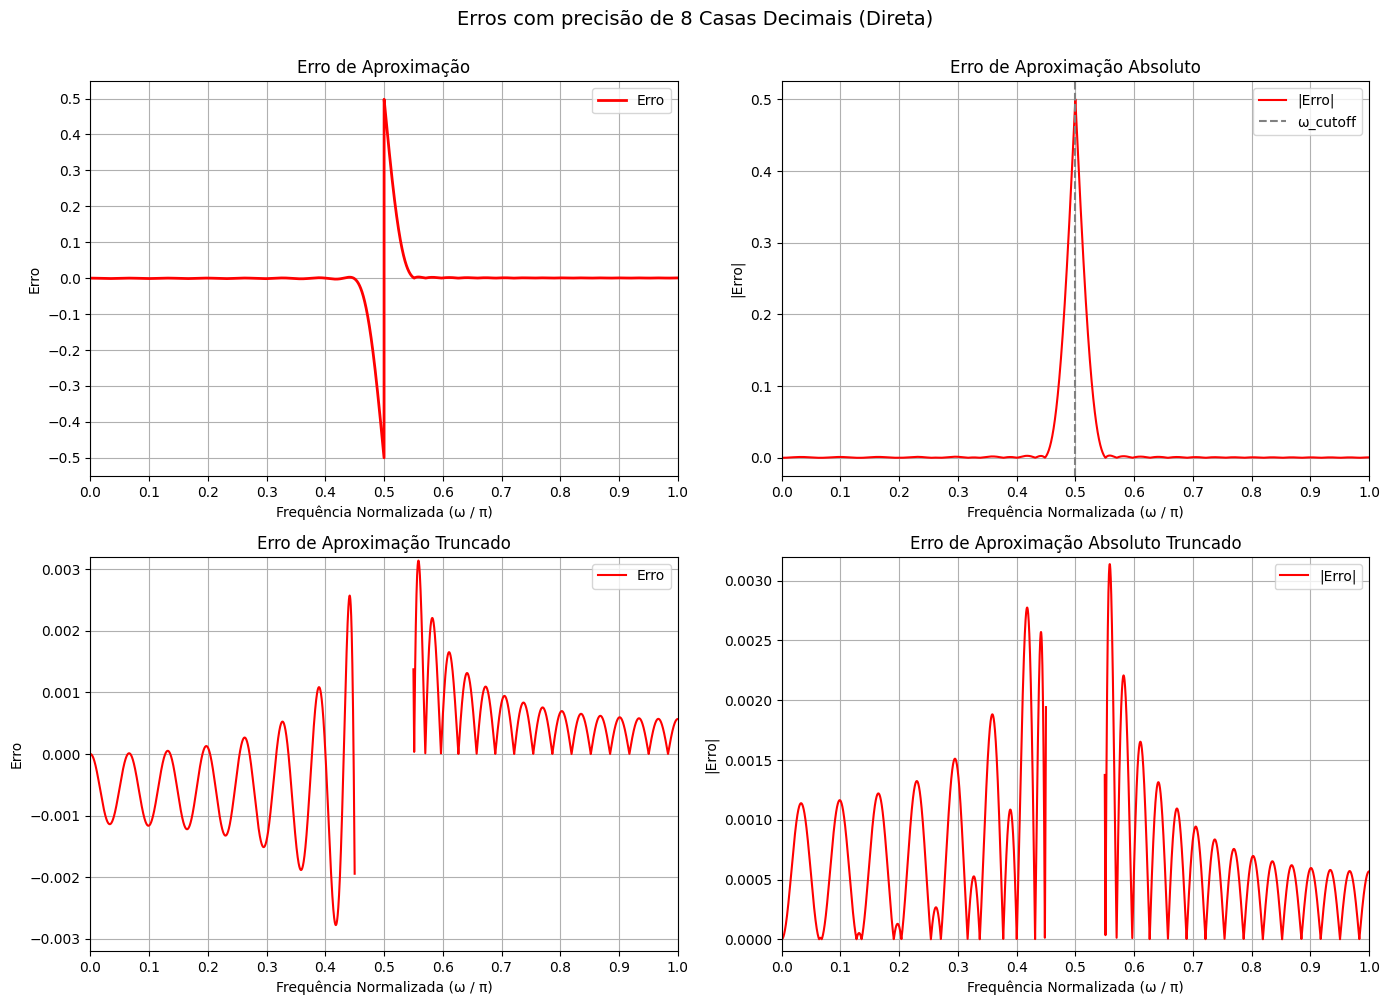

In [ ]:
# Erro de aproximação = H(ω) - LPF(ω)
erro_8dec = fir_direct_mag_8dec - lpf_ideal

# Erro de aproximação absoluto = |H(ω) - LPF(ω)|
erro_abs_8dec = abs(fir_direct_mag_8dec - lpf_ideal)

# Arrays de bools para truncar a resposta na faixa de transição
truncate_pass_8dec = omega_direct_norm_8dec <= w_pass / np.pi
truncate_stop_8dec = omega_direct_norm_8dec >= w_stop / np.pi

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Gráfico 1: Erro de aproximação
axes[0].plot(omega_direct_norm_8dec, erro_8dec, color='red', linewidth=2, label='Erro')
axes[0].set_title('Erro de Aproximação')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('Erro')
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0].set_yticks(np.arange(-0.5, 0.6, 0.1))
axes[0].set_xlim(0, 1)
axes[0].grid(True)
axes[0].legend()

# Gráfico 2: Erro absoluto de aproximação
axes[1].plot(omega_direct_norm_8dec, erro_abs_8dec, color='red', linewidth=1.5, label='|Erro|')
axes[1].axvline(w_cutoff / np.pi, color='grey', linestyle='--', label='ω_cutoff')
axes[1].set_title('Erro de Aproximação Absoluto')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('|Erro|')
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_xlim(0, 1)
axes[1].grid(True)
axes[1].legend()

# Gráfico 3: Erro de aproximação sem o pico para melhor visualização
axes[2].plot(omega_direct_norm_8dec[truncate_pass_8dec], erro_8dec[truncate_pass_8dec], color='red', linewidth=1.5, label='Erro')
axes[2].plot(omega_direct_norm_8dec[truncate_stop_8dec], erro_8dec[truncate_stop_8dec], color='red', linewidth=1.5)
axes[2].set_title('Erro de Aproximação Truncado')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Erro')
axes[2].set_xticks(np.arange(0, 1.1, 0.1))
axes[2].set_xlim(0, 1)
axes[2].set_ylim(-0.0032, 0.0032)
axes[2].grid(True)
axes[2].legend()

# Gráfico 4:  Erro de aproximação absoluto sem o pico para melhor visualização
axes[3].plot(omega_direct_norm_8dec[truncate_pass_8dec], erro_abs_8dec[truncate_pass_8dec], color='red', linewidth=1.5, label='|Erro|')
axes[3].plot(omega_direct_norm_8dec[truncate_stop_8dec], erro_abs_8dec[truncate_stop_8dec], color='red', linewidth=1.5)
axes[3].set_title('Erro de Aproximação Absoluto Truncado')
axes[3].set_xlabel('Frequência Normalizada (ω / π)')
axes[3].set_ylabel('|Erro|')
axes[3].set_xlim(0, 1)
axes[3].set_ylim(-0.0001, 0.0032)
axes[3].set_xticks(np.arange(0, 1.1, 0.1))
axes[3].grid(True)
axes[3].legend()

plt.suptitle('Erros com precisão de 8 Casas Decimais (Direta)', fontsize=14, y=1.0001)
plt.tight_layout()
plt.show()

# PARA 8 NÃO MUDOU 

In [ ]:
fir_direct_6dec = np.round(fir_direct, 6)

omega_direct_6dec, response_direct_6dec = freqz(fir_direct_6dec, worN=10192) # Calcula resposta do filtro na forma direta
omega_direct_norm_6dec = omega_direct_6dec / np.pi                        # Normaliza a frequência para o intervalo [0, 1]
fir_direct_mag_6dec = abs(response_direct_6dec)                        # |H(e^jw)|
response_direct_dB_6dec = 20 * np.log10(abs(response_direct_6dec))        # Resposta em dB
phase_direct_6dec = np.unwrap(np.angle(response_direct_6dec))                # Fase desembrulhada

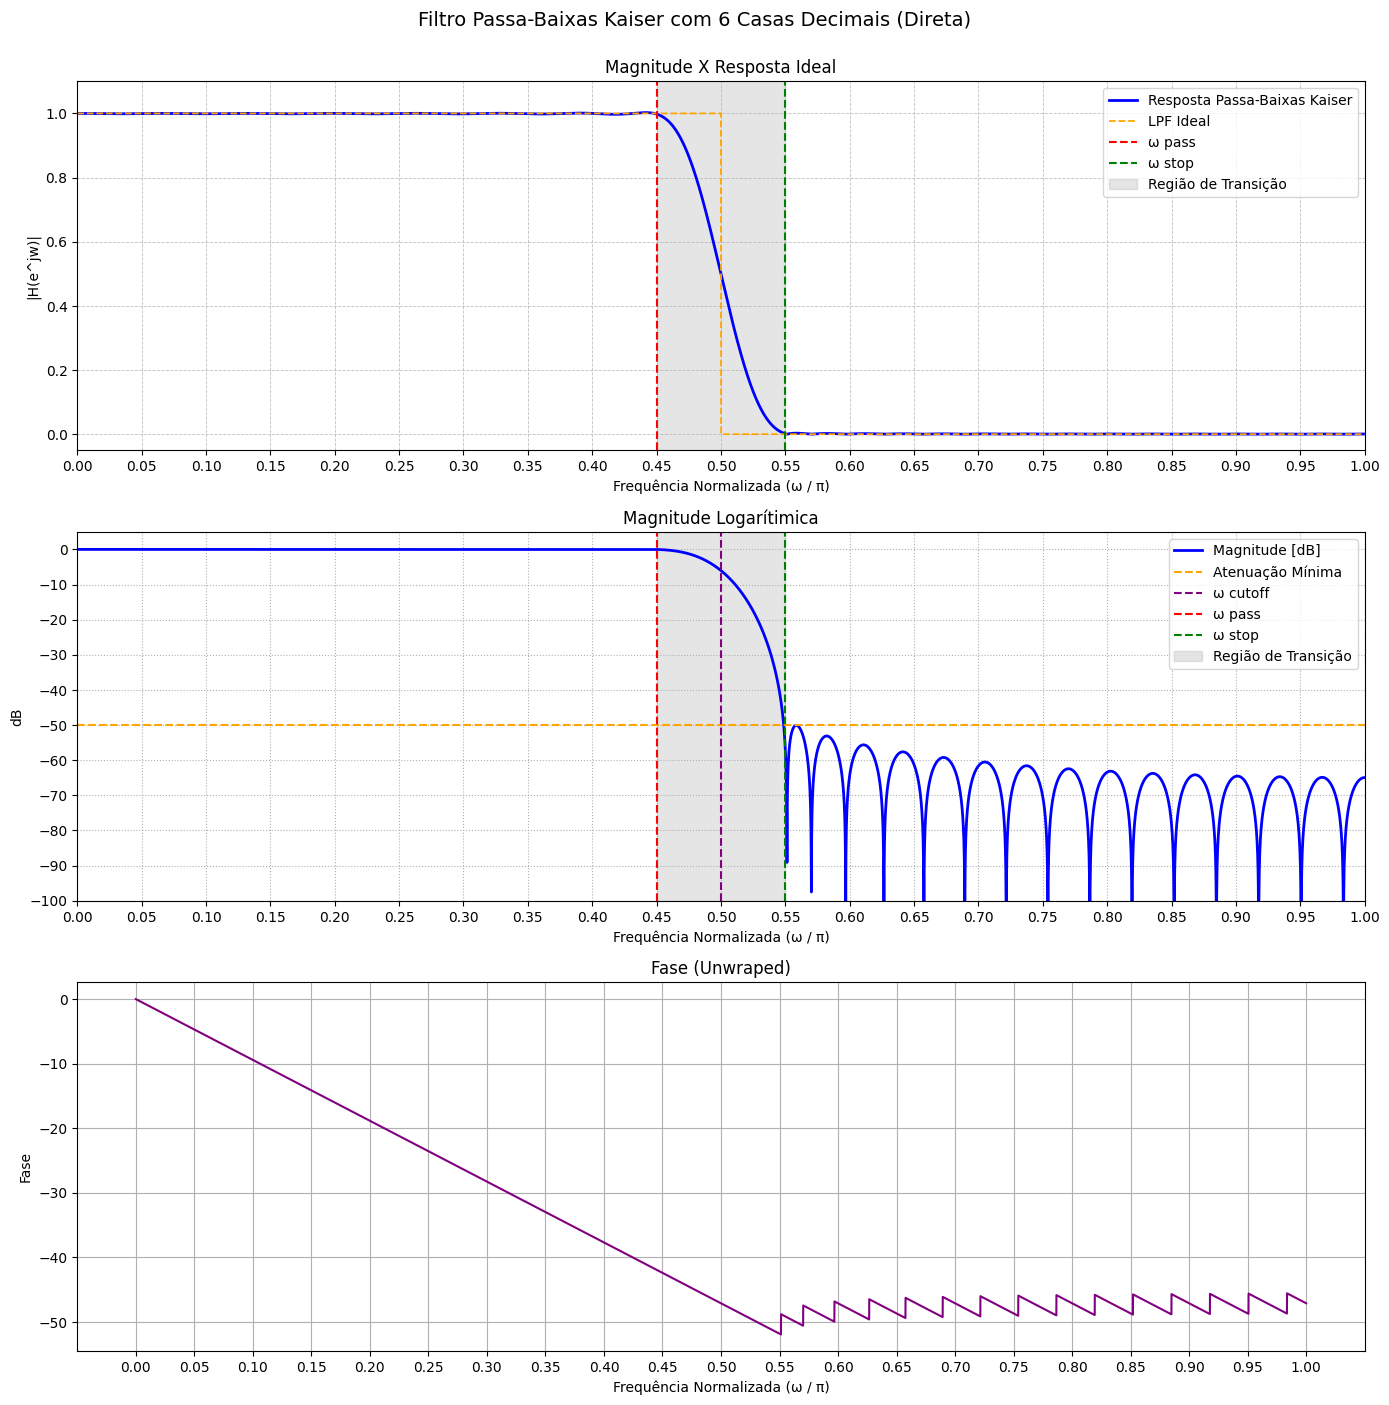

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Gráfico 1: |H(e^jw)|
axes[0].plot(omega_direct_norm_6dec, fir_direct_mag_6dec, label="Resposta Passa-Baixas Kaiser", color='blue', linewidth=2)
axes[0].plot(omega_direct_norm_6dec, lpf_ideal, color="orange", linestyle="--", linewidth=1.3, label="LPF Ideal")
axes[0].set_title('Magnitude X Resposta Ideal')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('|H(e^jw)|')
axes[0].set_xticks(np.arange(0, 1.05, 0.05))
axes[0].set_xlim(0, 1.0)
axes[0].set_ylim(-0.05, 1.1)
axes[0].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
axes[0].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
axes[0].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
axes[0].grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
axes[0].legend()

# Gráfico 2: Ganho em dB
axes[1].plot(omega_direct_norm_6dec, response_direct_dB_6dec, color='blue', linewidth=2, label='Magnitude [dB]')
axes[1].set_title('Magnitude Logarítimica')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('dB')
axes[1].set_xticks(np.arange(0, 1.05, 0.05))
axes[1].set_yticks(np.arange(-100, 10, 10))
axes[1].set_ylim(-100, 5)
axes[1].set_xlim(0, 1.0)
axes[1].axhline(-50, color='orange', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
axes[1].axvline(0.50, color='purple', linestyle='--', linewidth=1.5, label='ω cutoff')
axes[1].axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
axes[1].axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
axes[1].axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
axes[1].grid(True, which='both', linestyle=':', linewidth=0.8)
axes[1].legend()


# Gráfico 2: Fase
axes[2].plot(omega_direct_norm_6dec, phase_direct_6dec, color='purple')
axes[2].set_title('Fase (Unwraped)')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Fase')
axes[2].set_xticks(np.arange(0, 1.05, 0.05))
axes[2].grid(True)

plt.suptitle('Filtro Passa-Baixas Kaiser com 6 Casas Decimais (Direta)', fontsize=14, y=1.0001)
plt.tight_layout()
plt.show()

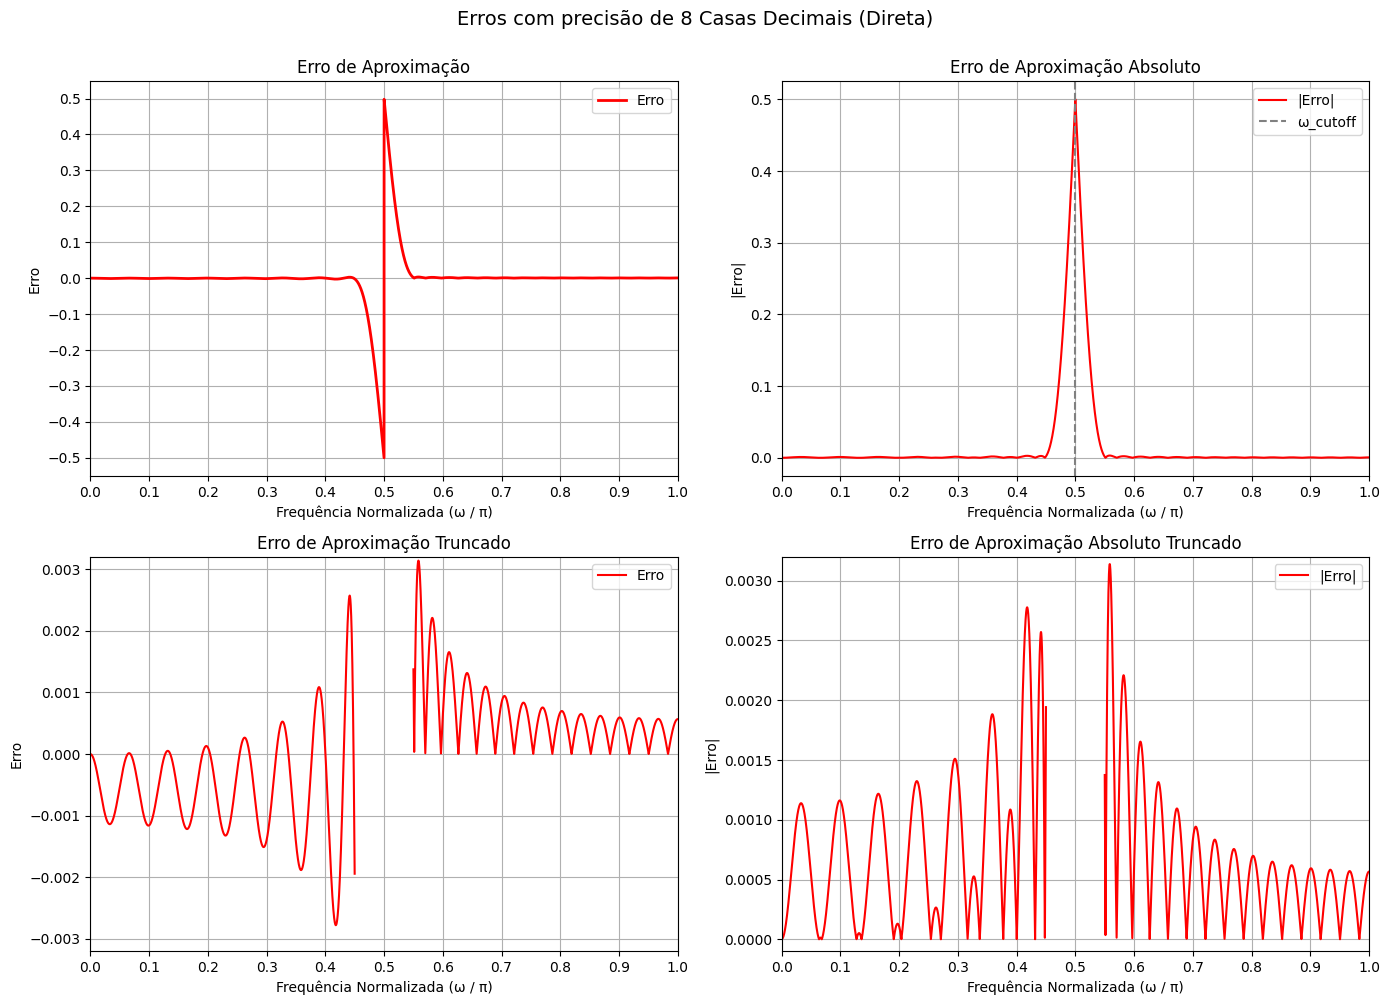

In [ ]:
# Erro de aproximação = H(ω) - LPF(ω)
erro_6dec = fir_direct_mag_6dec - lpf_ideal

# Erro de aproximação absoluto = |H(ω) - LPF(ω)|
erro_abs_6dec = abs(fir_direct_mag_6dec - lpf_ideal)

# Arrays de bools para truncar a resposta na faixa de transição
truncate_pass_6dec = omega_direct_norm_6dec <= w_pass / np.pi
truncate_stop_6dec = omega_direct_norm_6dec >= w_stop / np.pi

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Gráfico 1: Erro de aproximação
axes[0].plot(omega_direct_norm_6dec, erro_6dec, color='red', linewidth=2, label='Erro')
axes[0].set_title('Erro de Aproximação')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('Erro')
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0].set_yticks(np.arange(-0.5, 0.6, 0.1))
axes[0].set_xlim(0, 1)
axes[0].grid(True)
axes[0].legend()

# Gráfico 2: Erro absoluto de aproximação
axes[1].plot(omega_direct_norm_6dec, erro_abs_6dec, color='red', linewidth=1.5, label='|Erro|')
axes[1].axvline(w_cutoff / np.pi, color='grey', linestyle='--', label='ω_cutoff')
axes[1].set_title('Erro de Aproximação Absoluto')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('|Erro|')
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_xlim(0, 1)
axes[1].grid(True)
axes[1].legend()

# Gráfico 3: Erro de aproximação sem o pico para melhor visualização
axes[2].plot(omega_direct_norm_6dec[truncate_pass_6dec], erro_6dec[truncate_pass_6dec], color='red', linewidth=1.5, label='Erro')
axes[2].plot(omega_direct_norm_6dec[truncate_stop_6dec], erro_6dec[truncate_stop_6dec], color='red', linewidth=1.5)
axes[2].set_title('Erro de Aproximação Truncado')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Erro')
axes[2].set_xticks(np.arange(0, 1.1, 0.1))
axes[2].set_xlim(0, 1)
axes[2].set_ylim(-0.0032, 0.0032)
axes[2].grid(True)
axes[2].legend()

# Gráfico 4:  Erro de aproximação absoluto sem o pico para melhor visualização
axes[3].plot(omega_direct_norm_6dec[truncate_pass_6dec], erro_abs_6dec[truncate_pass_6dec], color='red', linewidth=1.5, label='|Erro|')
axes[3].plot(omega_direct_norm_6dec[truncate_stop_6dec], erro_abs_6dec[truncate_stop_6dec], color='red', linewidth=1.5)
axes[3].set_title('Erro de Aproximação Absoluto Truncado')
axes[3].set_xlabel('Frequência Normalizada (ω / π)')
axes[3].set_ylabel('|Erro|')
axes[3].set_xlim(0, 1)
axes[3].set_ylim(-0.0001, 0.0032)
axes[3].set_xticks(np.arange(0, 1.1, 0.1))
axes[3].grid(True)
axes[3].legend()

plt.suptitle('Erros com precisão de 8 Casas Decimais (Direta)', fontsize=14, y=1.0001)
plt.tight_layout()
plt.show()

# ANALISAR O DE 6. MAGNITUDE PARECE TER AUMENTADO A ONDULAÇÃO


In [ ]:
fir_direct_6dec = np.round(fir_direct, 6)

omega_direct_6dec, response_direct_6dec = freqz(fir_direct_6dec, worN=10192) # Calcula resposta do filtro na forma direta
omega_direct_norm_6dec = omega_direct_6dec / np.pi                        # Normaliza a frequência para o intervalo [0, 1]
fir_direct_mag_6dec = abs(response_direct_6dec)                        # |H(e^jw)|
response_direct_dB_6dec = 20 * np.log10(abs(response_direct_6dec))        # Resposta em dB
phase_direct_6dec = np.unwrap(np.angle(response_direct_6dec))                # Fase desembrulhada